This notebook tests the web scraping code.

In [1]:
import requests
from bs4 import BeautifulSoup
import networkx as nx
from gensim import corpora
import nltk
from nltk.corpus import stopwords
from gensim.models.ldamodel import LdaModel
import re
from urllib.robotparser import RobotFileParser
from urllib.parse import urljoin, urldefrag, urlparse
from collections import deque
import time

In [2]:

# Ensure NLTK stopwords are downloaded
# Uncomment the following line if you haven't downloaded stopwords yet
# nltk.download('stopwords')

# Define stopwords
stop_words = set(stopwords.words('english'))

In [3]:
# Helper function to clean text
def clean_text(text):
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', ' ', text)
    # Convert to lowercase and split into words
    words = text.lower().split()
    # Remove stopwords
    words = [word for word in words if word not in stop_words]
    # Join words back into a single string
    cleaned_text = ' '.join(words)
    return cleaned_text

In [4]:
def crawl_website(base_url, max_pages=50):
    visited = set()  # Keep track of visited pages
    to_visit = deque([base_url])  # Efficient queue of pages to visit
    to_visit_set = set([base_url])  # Set for quick lookup to avoid duplicates

    scraped_content = []  # To store scraped content from the pages
    graph = nx.DiGraph()  # Initialize the graph

    # Initialize the robots.txt parser
    robot_parser = RobotFileParser()
    robot_parser.set_url(urljoin(base_url, '/robots.txt'))
    try:
        robot_parser.read()
    except Exception as e:
        print(f"Error reading robots.txt: {e}")
        return scraped_content, graph

    # Get the crawl-delay (if any)
    crawl_delay = robot_parser.crawl_delay('*') or 0

    session = requests.Session()  # Use a session for connection pooling

    while to_visit and len(visited) < max_pages:
        url = to_visit.popleft()
        to_visit_set.remove(url)

        # Remove URL fragments (like #section1) to avoid duplicate pages
        url, _ = urldefrag(url)

        if url in visited or not url.startswith(base_url):
            continue

        # Check if the URL is allowed to be crawled based on robots.txt
        if not robot_parser.can_fetch('*', url):
            print(f"Skipping {url} due to robots.txt restrictions.")
            continue

        try:
            response = session.get(url, timeout=10)
            if response.status_code != 200:
                continue

            # Set the correct encoding
            response.encoding = response.apparent_encoding

            # Mark this URL as visited
            visited.add(url)

            # Parse the HTML content
            soup = BeautifulSoup(response.text, 'html.parser')

            # Add this page as a node in the graph
            graph.add_node(url)

            # Debugging: Print the current URL
            print(f"Visiting: {url}")

            # Extract all links on the page
            for link in soup.find_all('a', href=True):
                raw_link = link['href']
                # Skip empty and anchor-only links
                if not raw_link or raw_link.startswith('#'):
                    continue

                # Create a full URL using urljoin
                full_url = urljoin(url, raw_link)  # Use current url as base

                # Remove URL fragments
                full_url, _ = urldefrag(full_url)

                # Normalize URL to avoid duplicates
                parsed_full_url = urlparse(full_url)
                normalized_full_url = parsed_full_url._replace(
                    params='', query='', fragment=''
                ).geturl()

                # Ensure the URL starts with the base domain and is not already visited or queued
                if (
                    normalized_full_url.startswith(base_url)
                    and normalized_full_url not in visited
                    and normalized_full_url not in to_visit_set
                ):
                    to_visit.append(normalized_full_url)
                    to_visit_set.add(normalized_full_url)
                    graph.add_edge(url, normalized_full_url)  # Add directed edge

            # Extract and clean text content
            page_text = soup.get_text(separator=' ')
            cleaned_text = clean_text(page_text)
            scraped_content.append(cleaned_text)

            # Respect crawl-delay
            if crawl_delay > 0:
                time.sleep(crawl_delay)

        except requests.RequestException as e:
            print(f"Error accessing {url}: {e}")
            continue

    return scraped_content, graph

In [5]:
scraped_content, graph = crawl_website(base_url= 'https://www.churchofjesuschrist.org/?lang=eng', max_pages=5)

Visiting: https://www.churchofjesuschrist.org/?lang=eng


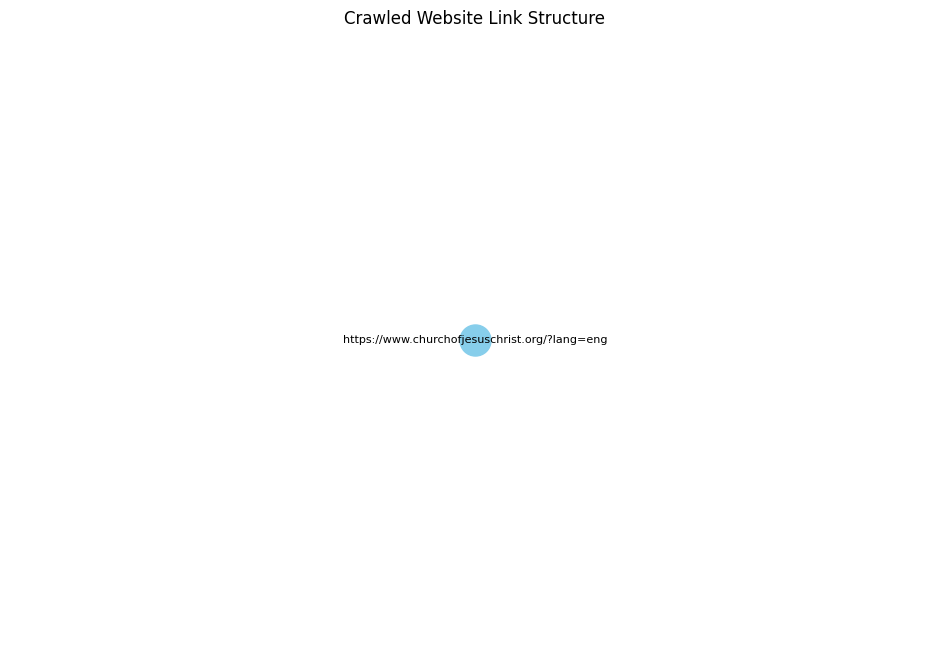

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Assuming you have already run your crawler and have the 'graph' variable
# scraped_content, graph = crawl_website(base_url, max_pages=5)

def visualize_graph(graph):
    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(graph, k=0.5, iterations=50)

    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, node_size=500, node_color='skyblue')

    # Draw edges
    nx.draw_networkx_edges(
        graph, pos,
        arrowstyle='->',
        arrowsize=20,
        edge_color='gray',
        connectionstyle='arc3, rad=0.1'
    )

    # Draw node labels
    nx.draw_networkx_labels(graph, pos, font_size=8, font_family='sans-serif')

    # Set title and remove axes
    plt.title("Crawled Website Link Structure")
    plt.axis('off')

    # Display the graph
    plt.show()

# Call the visualization function
visualize_graph(graph)


In [7]:
# Print the content of the first page
print("Content of the first page:")
print(scraped_content[0][:500])  # Print first 500 characters

# Count word frequencies
from collections import Counter

all_words = ' '.join(scraped_content).split()
word_counts = Counter(all_words)

# Print the most common words
print("Most common words:")
for word, count in word_counts.most_common(10):
    print(f"{word}: {count}")

Content of the first page:
homepage church jesus christ latter day saints draw closer jesus christ join us general conference october 5 6 learn believe learn church jesus christ latter day saints learn jesus christ get know follow find meaning life seek god perspective navigate life challenges discover strength direction peace welcome visit church near christ focused community best love serve others place find church near find common questions members church jesus christ latter day saints christian yes members church jesu
Most common words:
jesus: 23
christ: 22
church: 20
us: 11
god: 11
latter: 10
day: 10
saints: 10
learn: 9
book: 8
